In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models

In [2]:
IMAGE_SIZE = 224
BATCH_SIZE = 32

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "datasets/grape",
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 12000 files belonging to 4 classes.


In [4]:
class_names = dataset.class_names

In [5]:
class_names

['Black Rot', 'ESCA', 'Healthy', 'Leaf Blight']

In [6]:
len(dataset) # one batch has 375 images so, 32 batches have 12000 in total

375

In [7]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 224, 224, 3)
[0 0 0 3 3 3 2 1 3 0 3 0 0 3 2 2 1 3 1 1 0 1 3 3 3 3 2 2 2 0 1 3]


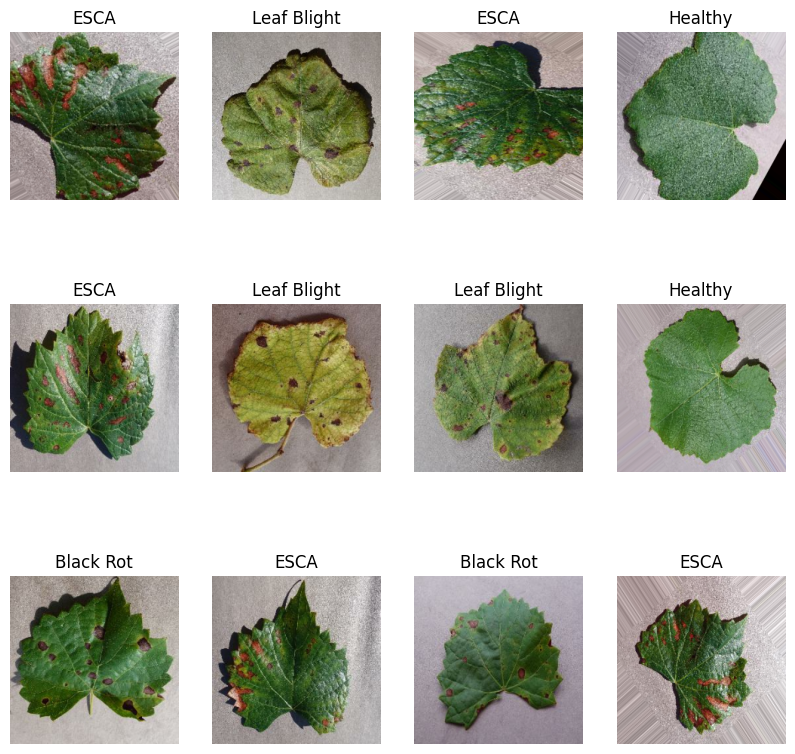

In [8]:
plt.figure(figsize = (10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.axis('off')
        plt.title(class_names[label_batch[i]])

80 % --> Training
20 % --> 10 % Testing 10 % Validation

In [9]:
train_size = 0.8
test_size = 0.2
len(dataset)*train_size

300.0

In [10]:
train_dataset = dataset.take(300)
len(train_dataset)

300

In [11]:
test_dataset = dataset.skip(300)
len(test_dataset)

75

In [12]:
val_size = 0.1
len(dataset)*val_size

37.5

In [13]:
validation_dataset = test_dataset.take(37)
len(validation_dataset)

37

In [14]:
test_dataset = test_dataset.skip(37)
len(test_dataset)

38

In [15]:
print(len(train_dataset))
print(len(validation_dataset))
print(len(test_dataset))

300
37
38


In [16]:
# To automate the splitting procedure without hardcoding train-val-test sizes

def get_dataset_partitions(ds, train_split = 0.8, 
                           val_split = 0.1, 
                           test_split = 0.1, 
                           shuffle = True, 
                           shuffle_size = 10000):

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 10)
        
    ds_size = len(ds)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [17]:
train_dataset, val_dataset, test_dataset = get_dataset_partitions(dataset)

In [18]:
len(train_dataset)

300

In [19]:
len(val_dataset)

37

In [20]:
len(test_dataset)

38

In [21]:
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_dataset = val_dataset.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [22]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255),
])

In [23]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal_and_vertical'),
    layers.RandomRotation(0.2)
])

In [24]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, 3)
n_classes = 4

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(n_classes, activation = 'softmax')
])

model.build(input_shape = input_shape)

c:\Users\jrsak\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [25]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 224, 224, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (32, 224, 224, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 222, 222, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 111, 111, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 109, 109, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 54, 54, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 52, 52, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 26, 26, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 24, 24, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 12, 12, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 10, 10, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 5, 5, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 3, 3, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 1, 1, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 64)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 4)                │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 171,524 (670.02 KB)

 Trainable params: 171,524 (670.02 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer = 'adam',
             loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
             metrics = ['accuracy'])

history = model.fit(train_dataset,
         epochs = 25,
         batch_size = BATCH_SIZE,
         verbose = 1,
         validation_data = val_dataset)

In [ ]:
scores = model.evaluate(test_dataset)

38/38 ━━━━━━━━━━━━━━━━━━━━ 229s 572ms/step - accuracy: 0.9936 - loss: 0.0230


In [ ]:
scores

[0.023866409435868263, 0.9917762875556946]

None
